# Minimal Media Mix Model Example

This notebook demonstrates fitting a minimal Media Mix Model (MMM) using PyMC-Marketing with default parameters on synthetic marketing data.

## Dataset Overview

The dataset contains:
- **Time period**: 104 weeks (2 years) from 2020-01-05 to 2021-12-26
- **Marketing channels**: Search Ads, Social Media, Local Ads, Email
- **Control variables**: Event (c1), Sale (c2)
- **Target**: Weekly sales (y)

See `DATA.md` for complete dataset documentation.

## Setup

In [1]:
from pathlib import Path

import polars as pl
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from rich import print as rprint
from rich.console import Console
from rich.table import Table

## Load Data

Load the main MMM dataset using Polars for efficient data handling.

In [2]:
def load_mmm_data(data_path: str | Path) -> pl.DataFrame:
    """Load MMM data from CSV file.
    
    Args:
        data_path: Path to the mmm_data.csv file
        
    Returns:
        Polars DataFrame with parsed date column
    """
    return pl.read_csv(data_path).with_columns(
        pl.col("date").str.to_date()
    )


# Load the data
data_path = Path("../data/mmm-simple/mmm_data.csv")
df = load_mmm_data(data_path)

rprint(f"[bold green]Data loaded successfully[/bold green]")
rprint(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
rprint(f"Date range: {df['date'].min()} to {df['date'].max()}")

Data loaded successfully

Shape: 104 rows × 11 columns

Date range: 2020-01-05 to 2021-12-26

## Data Preview

In [3]:
def display_data_preview(df: pl.DataFrame, n_rows: int = 5) -> None:
    """Display data preview using Rich table.
    
    Args:
        df: Input DataFrame
        n_rows: Number of rows to display
    """
    console = Console()
    table = Table(title="MMM Data Preview", show_header=True, header_style="bold magenta")
    
    # Add columns
    for col in df.columns:
        table.add_column(col)
    
    # Add rows
    for row in df.head(n_rows).iter_rows():
        table.add_row(*[str(val) for val in row])
    
    console.print(table)


display_data_preview(df)

                                                 MMM Data Preview                                                  
┏━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ date      ┃ geo   ┃ x1_Searc… ┃ x2_Socia… ┃ x3_Local… ┃ x4_Email  ┃ c1  ┃ c1_effe… ┃ c2  ┃ c2_effect ┃ y        ┃
┡━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ 2020-01-… │ Local │ 77.49705… │ 0.0       │ 773.9565… │ 0.0       │ 0.0 │ 0.0      │ 0.0 │ 0.0       │ 8121.95… │
│ 2020-01-… │ Local │ 0.0       │ 0.0       │ 258.3657… │ 105.6407… │ 0.0 │ 0.0      │ 0.0 │ 0.0       │ 8875.90… │
│ 2020-01-… │ Local │ 91.89115… │ 0.0       │ 301.5111… │ 0.0       │ 0.0 │ 0.0      │ 0.0 │ 0.0       │ 7401.80… │
│ 2020-01-… │ Local │ 0.0       │ 0.0       │ 1052.158… │ 0.0       │ 0.0 │ 0.0      │ 0.0 │ 0.0       │ 7707.94… │
│ 2020-02-… │ Local │ 0.0       │ 0.0       │ 0.0       │ 110.3024… │ 0.0 │ 0.0      │ 0.0 │ 0.0       │ 9733.30… │
└───────────┴───────┴───────────┴───────────┴───────────┴───────────┴─────┴──────────┴─────┴───────────┴──────────┘

## Data Summary Statistics

In [4]:
def display_summary_stats(df: pl.DataFrame) -> None:
    """Display summary statistics for numeric columns.
    
    Args:
        df: Input DataFrame
    """
    # Select numeric columns (excluding date and geo)
    numeric_cols = [col for col in df.columns if col not in ["date", "geo"]]
    
    stats = df.select(numeric_cols).describe()
    
    console = Console()
    table = Table(title="Summary Statistics", show_header=True, header_style="bold cyan")
    
    # Add columns
    table.add_column("Statistic")
    for col in stats.columns:
        table.add_column(col)
    
    # Add rows
    for row in stats.iter_rows():
        table.add_row(*[f"{val:.2f}" if isinstance(val, float) else str(val) for val in row])
    
    console.print(table)


display_summary_stats(df)

                                                Summary Statistics                                                 
┏━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━┓
┃ Statistic ┃ statistic ┃ x1_Sear… ┃ x2_Socia… ┃ x3_Loca… ┃ x4_Email ┃ c1     ┃ c1_effect ┃ c2     ┃ c2_effe… ┃ y ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━┩
│ count     │ 104.00    │ 104.00   │ 104.00    │ 104.00   │ 104.00   │ 104.00 │ 104.00    │ 104.00 │ 104.00   │   │
│ null_cou… │ 0.00      │ 0.00     │ 0.00      │ 0.00     │ 0.00     │ 0.00   │ 0.00      │ 0.00   │ 0.00     │   │
│ mean      │ 152.11    │ 19.78    │ 244.83    │ 17.57    │ 14.48    │ 7.44   │ 6.82      │ 3.41   │ 8522.81  │   │
│ std       │ 141.75    │ 40.08    │ 311.18    │ 43.84    │ 42.19    │ 21.66  │ 20.65     │ 10.33  │ 2021.52  │   │
│ min       │ 0.00      │ 0.00     │ 0.00      │ 0.00     │ 0.00     │ 0.00   │ 0.00      │ 0.00   │ 4723.87  │   │
│ 25%       │ 33.85     │ 0.00     │ 0.00      │ 0.00     │ 0.00     │ 0.00   │ 0.00      │ 0.00   │ 7039.75  │   │
│ 50%       │ 121.19    │ 0.00     │ 0.00      │ 0.00     │ 0.00     │ 0.00   │ 0.00      │ 0.00   │ 8390.58  │   │
│ 75%       │ 248.84    │ 18.94    │ 502.93    │ 0.00     │ 0.00     │ 0.00   │ 0.00      │ 0.00   │ 9719.46  │   │
│ max       │ 654.89    │ 201.80   │ 1052.16   │ 216.53   │ 200.75   │ 103.08 │ 147.27    │ 73.67  │ 13782.07 │   │
└───────────┴───────────┴──────────┴───────────┴──────────┴──────────┴────────┴───────────┴────────┴──────────┴───┘

## Prepare Data for MMM

Convert to pandas DataFrame (required by PyMC-Marketing) and define channel columns.

In [5]:
# Convert to pandas (PyMC-Marketing currently requires pandas)
df_pandas = df.to_pandas()

# Define model inputs
channel_columns = [
    "x1_Search-Ads",
    "x2_Social-Media",
    "x3_Local-Ads",
    "x4_Email"
]

control_columns = ["c1", "c2"]

rprint("[bold blue]Model Configuration:[/bold blue]")
rprint(f"Target column: [yellow]y[/yellow]")
rprint(f"Date column: [yellow]date[/yellow]")
rprint(f"Channel columns: [yellow]{channel_columns}[/yellow]")
rprint(f"Control columns: [yellow]{control_columns}[/yellow]")

Model Configuration:

Target column: y

Date column: date

Channel columns: ['x1_Search-Ads', 'x2_Social-Media', 'x3_Local-Ads', 'x4_Email']

Control columns: ['c1', 'c2']

## Initialize MMM Model

Create an `MMM` model with default geometric adstock and logistic saturation.

In [6]:
def create_mmm_model(
    date_column: str,
    channel_columns: list[str],
    control_columns: list[str],
    adstock_max_lag: int = 8,
    yearly_seasonality: int = 2
) -> MMM:
    """Create an MMM model instance.
    
    Args:
        date_column: Name of date column
        channel_columns: List of marketing channel column names
        control_columns: List of control variable column names
        adstock_max_lag: Maximum lag for adstock transformation
        yearly_seasonality: Number of Fourier modes for yearly seasonality
        
    Returns:
        Initialized MMM model instance
    """
    return MMM(
        date_column=date_column,
        channel_columns=channel_columns,
        control_columns=control_columns,
        adstock=GeometricAdstock(l_max=adstock_max_lag),
        saturation=LogisticSaturation(),
        yearly_seasonality=yearly_seasonality
    )


# Initialize model
mmm = create_mmm_model(
    date_column="date",
    channel_columns=channel_columns,
    control_columns=control_columns,
    adstock_max_lag=8,
    yearly_seasonality=2
)

rprint("[bold green]MMM model initialized successfully[/bold green]")

MMM model initialized successfully

## Fit the Model

Fit the MMM model using MCMC sampling with default parameters.

**Note**: This may take several minutes depending on your hardware.

In [7]:
import pandas as pd


def fit_mmm(
    model: MMM,
    X: pd.DataFrame,
    y: pd.Series,
    draws: int = 1000,
    tune: int = 1000,
    chains: int = 2,
    random_seed: int = 42
) -> None:
    """Fit MMM model to data.
    
    Args:
        model: MMM model instance
        X: Input features DataFrame
        y: Target variable Series
        draws: Number of MCMC draws per chain
        tune: Number of tuning steps
        chains: Number of MCMC chains
        random_seed: Random seed for reproducibility
    """
    rprint("[bold yellow]Starting model fitting...[/bold yellow]")
    rprint(f"Draws: {draws}, Tune: {tune}, Chains: {chains}")
    
    model.fit(
        X=X,
        y=y,
        draws=draws,
        tune=tune,
        chains=chains,
        random_seed=random_seed
    )
    
    rprint("[bold green]Model fitting completed successfully![/bold green]")


# Prepare X and y
X = df_pandas.drop(columns=["y"])
y = df_pandas["y"]

# Fit the model
fit_mmm(
    model=mmm,
    X=X,
    y=y,
    draws=1000,
    tune=1000,
    chains=2,
    random_seed=42
)

Starting model fitting...

Draws: 1000, Tune: 1000, Chains: 2

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Output()

Model fitting completed successfully!

## Model Summary

Display model fit summary statistics.

In [8]:
import arviz as az


def display_fit_summary(model: MMM) -> None:
    """Display model fit summary.
    
    Args:
        model: Fitted MMM model
    """
    summary = az.summary(model.idata)
    rprint("[bold magenta]Model Fit Summary:[/bold magenta]")
    rprint(summary)


display_fit_summary(mmm)

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/lfiaschi/Do

Model Fit Summary:

mean       sd  \
intercept                                            0.406    0.014   
adstock_alpha[x1_Search-Ads]                         0.047    0.040   
adstock_alpha[x2_Social-Media]                       0.183    0.068   
adstock_alpha[x3_Local-Ads]                          0.353    0.096   
adstock_alpha[x4_Email]                              0.267    0.039   
...                                                    ...      ...   
y_original_scale[2021-11-28T00:00:00.000000000]   6418.951  206.085   
y_original_scale[2021-12-05T00:00:00.000000000]  10162.995  213.925   
y_original_scale[2021-12-12T00:00:00.000000000]   7887.525  205.118   
y_original_scale[2021-12-19T00:00:00.000000000]  10435.833  205.569   
y_original_scale[2021-12-26T00:00:00.000000000]  10210.188  192.529   

                                                    hdi_3%    hdi_97%  \
intercept                                            0.375      0.430   
adstock_alpha[x1_Search-Ads]                         0.000      0.120   
adstock_alpha[x2_Social-Media]                       0.053      0.311   
adstock_alpha[x3_Local-Ads]                          0.173      0.530   
adstock_alpha[x4_Email]                              0.195      0.341   
...                                                    ...        ...   
y_original_scale[2021-11-28T00:00:00.000000000]   6059.917   6832.295   
y_original_scale[2021-12-05T00:00:00.000000000]   9764.555  10574.998   
y_original_scale[2021-12-12T00:00:00.000000000]   7510.417   8269.572   
y_original_scale[2021-12-19T00:00:00.000000000]  10063.002  10821.134   
y_original_scale[2021-12-26T00:00:00.000000000]   9839.531  10570.449   

                                                 mcse_mean  mcse_sd  ess_bulk  \
intercept                                            0.000    0.000    1276.0   
adstock_alpha[x1_Search-Ads]                         0.001    0.001    1438.0   
adstock_alpha[x2_Social-Media]                       0.002    0.002    1675.0   
adstock_alpha[x3_Local-Ads]                          0.002    0.002    1673.0   
adstock_alpha[x4_Email]                              0.001    0.001    1993.0   
...                                                    ...      ...       ...   
y_original_scale[2021-11-28T00:00:00.000000000]      4.811    4.040    1827.0   
y_original_scale[2021-12-05T00:00:00.000000000]      4.616    4.156    2167.0   
y_original_scale[2021-12-12T00:00:00.000000000]      5.339    4.061    1479.0   
y_original_scale[2021-12-19T00:00:00.000000000]      4.786    3.760    1845.0   
y_original_scale[2021-12-26T00:00:00.000000000]      4.468    3.525    1869.0   

                                                 ess_tail  r_hat  
intercept                                          1063.0    1.0  
adstock_alpha[x1_Search-Ads]                       1081.0    1.0  
adstock_alpha[x2_Social-Media]                      860.0    1.0  
adstock_alpha[x3_Local-Ads]                        1219.0    1.0  
adstock_alpha[x4_Email]                            1267.0    1.0  
...                                                   ...    ...  
y_original_scale[2021-11-28T00:00:00.000000000]    1711.0    1.0  
y_original_scale[2021-12-05T00:00:00.000000000]    1470.0    1.0  
y_original_scale[2021-12-12T00:00:00.000000000]    1484.0    1.0  
y_original_scale[2021-12-19T00:00:00.000000000]    1551.0    1.0  
y_original_scale[2021-12-26T00:00:00.000000000]    1675.0    1.0  

[2205 rows x 9 columns]

## Channel Contributions

Compute channel contributions over time.

In [9]:
def compute_channel_contributions(model: MMM) -> pd.DataFrame:
    """Compute mean channel contributions over time in original scale.
    
    Args:
        model: Fitted MMM model
        
    Returns:
        DataFrame with channel contributions in original scale
    """
    contributions = model.compute_mean_contributions_over_time(original_scale=True)
    rprint("[bold green]Channel contributions computed (original scale)[/bold green]")
    return contributions


contributions = compute_channel_contributions(mmm)
rprint(contributions.head())

Channel contributions computed (original scale)

x1_Search-Ads  x2_Social-Media  x3_Local-Ads     x4_Email   c1  \
date                                                                         
2020-01-05     658.057712              0.0   1083.342473     0.000000  0.0   
2020-01-12      30.695452              0.0    811.845106  2830.055132  0.0   
2020-01-19     779.847622              0.0    766.144034   783.386757  0.0   
2020-01-26      36.660242              0.0   1455.095403   213.372652  0.0   
2020-02-02       2.944879              0.0    687.905293  2995.956542  0.0   

             c2  yearly_seasonality    intercept  
date                                              
2020-01-05  0.0         -239.881295  5590.602818  
2020-01-12  0.0          -85.128956  5590.602818  
2020-01-19  0.0           77.801800  5590.602818  
2020-01-26  0.0          245.561620  5590.602818  
2020-02-02  0.0          414.387439  5590.602818

## Compute ROAS

Calculate Return on Ad Spend (ROAS) for each channel and compare with ground truth.

In [10]:
import json


def compute_and_compare_roas(
    contributions: pd.DataFrame,
    channel_spend: pd.DataFrame,
    channel_columns: list[str],
    ground_truth_path: str | Path
) -> None:
    """Compute ROAS and compare with ground truth.
    
    Args:
        contributions: DataFrame with channel contributions
        channel_spend: DataFrame with channel spend data
        channel_columns: List of channel column names
        ground_truth_path: Path to ground truth parameters JSON
    """
    # Compute ROAS: total contribution / total spend
    total_contributions = contributions[channel_columns].sum()
    total_spend = channel_spend[channel_columns].sum()
    roas = total_contributions / total_spend
    
    # Load ground truth
    with open(ground_truth_path) as f:
        ground_truth = json.load(f)
    
    true_roas = ground_truth["roas_values"]["Local"]
    
    # Create comparison table
    console = Console()
    table = Table(
        title="ROAS Comparison: Estimated vs Ground Truth",
        show_header=True,
        header_style="bold green"
    )
    
    table.add_column("Channel", style="cyan")
    table.add_column("Estimated ROAS", justify="right")
    table.add_column("True ROAS", justify="right")
    table.add_column("Error %", justify="right")
    
    for channel in channel_columns:
        # Extract base channel name (remove x1_, x2_, etc. prefix)
        channel_name = channel.split('_', 1)[1] if '_' in channel else channel
        
        est_val = roas[channel]
        true_val = true_roas.get(channel_name, 0.0)
        error_pct = ((est_val - true_val) / true_val * 100) if true_val != 0 else 0.0
        
        table.add_row(
            channel_name,
            f"{est_val:.2f}",
            f"{true_val:.2f}",
            f"{error_pct:+.1f}%"
        )
    
    console.print(table)


# Compute and compare ROAS
ground_truth_path = Path("../data/mmm-simple/ground_truth_parameters.json")
compute_and_compare_roas(
    contributions=contributions,
    channel_spend=df_pandas,
    channel_columns=channel_columns,
    ground_truth_path=ground_truth_path
)

      ROAS Comparison: Estimated vs Ground Truth       
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┓
┃ Channel      ┃ Estimated ROAS ┃ True ROAS ┃ Error % ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━┩
│ Search-Ads   │           7.92 │      8.19 │   -3.3% │
│ Social-Media │          29.95 │     21.95 │  +36.5% │
│ Local-Ads    │           2.25 │      3.32 │  -32.1% │
│ Email        │          36.30 │     32.13 │  +13.0% │
└──────────────┴────────────────┴───────────┴─────────┘

## Model Diagnostics

Plot trace plots and posterior distributions for key parameters.

Plotting trace diagnostics...

/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/lfiaschi/Documents/workspace/blog-optuna-pymc-marketing/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


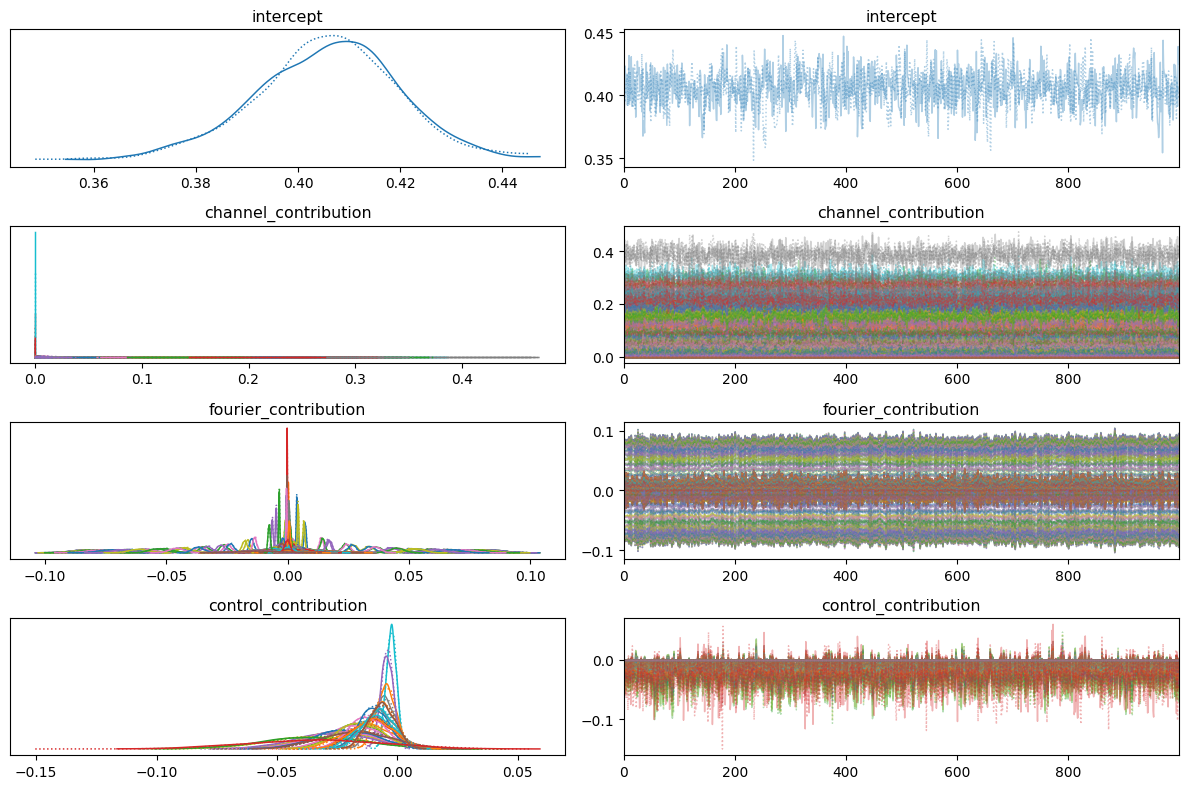

In [14]:
import arviz as az
import matplotlib.pyplot as plt


def plot_trace_diagnostics(model: MMM) -> None:
    """Plot MCMC trace diagnostics.
    
    Args:
        model: Fitted MMM model
    """
    rprint("[bold blue]Plotting trace diagnostics...[/bold blue]")
    
    # Plot trace for key parameters
    az.plot_trace(
        model.idata,
        var_names=["intercept", "channel_contribution", "fourier_contribution","control_contribution"],
        compact=True,
        figsize=(12, 8)
    )
    plt.tight_layout()
    plt.show()


plot_trace_diagnostics(mmm)

## Save Model

Save the fitted model for later use.

In [ ]:
def save_model(model: MMM, output_path: str | Path) -> None:
    """Save fitted model to disk.
    
    Args:
        model: Fitted MMM model
        output_path: Path to save model
    """
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    model.save(str(output_path))
    rprint(f"[bold green]Model saved to {output_path}[/bold green]")


# Save model
model_output_path = Path("../models/mmm_minimal_default.nc")
save_model(mmm, model_output_path)

## Summary

This notebook demonstrated:

1. Loading synthetic MMM data with Polars
2. Initializing an `MMM` model with GeometricAdstock and LogisticSaturation
3. Fitting the model using MCMC sampling
4. Computing channel contributions and ROAS
5. Comparing estimated ROAS with ground truth values
6. Visualizing model diagnostics
7. Saving the fitted model

### Next Steps

- Experiment with different priors and model configurations
- Optimize hyperparameters using Optuna
- Analyze adstock and saturation parameters
- Perform out-of-sample validation